## 1.

*Recogiendo los datos de coronavirus de la página https://ourworldindata.org/coronavirus-source-data* 

A partir de la letra de tu DNI, elige al país que empieza por dicha letra que más fallecidos tenga. Si el país elegido no está entre el top 20 de fallecidos, elige como país España.

En este caso, utilizaremos las columnas:

- Nuevos casos
- Nuevos fallecidos
- Población
- Fallecidos totales
- Casos totales

La fecha debe estar en el índice.

1. Representa todas las columnas en un gráfica con diferentes magnitudes en el eje y para su correcta visualización.

2. Elimina la columna "Población".

3. Entrena los algoritmos de regresión que hemos visto hasta ahora para predecir dos columnas por separado: Nuevos casos y Nuevos fallecidos. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

4. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y n_repeats = 7 para este ejercicio y solo para la columna "nuevos casos".

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
covid = pd.read_csv('../data/owid-covid-data.csv')
covid

iso_code continent     location        date  total_cases  new_cases  \
0          AFG      Asia  Afghanistan  2020-02-24          1.0        1.0   
1          AFG      Asia  Afghanistan  2020-02-25          1.0        0.0   
2          AFG      Asia  Afghanistan  2020-02-26          1.0        0.0   
3          AFG      Asia  Afghanistan  2020-02-27          1.0        0.0   
4          AFG      Asia  Afghanistan  2020-02-28          1.0        0.0   
...        ...       ...          ...         ...          ...        ...   
97384      ZWE    Africa     Zimbabwe  2021-06-17      40927.0      371.0   
97385      ZWE    Africa     Zimbabwe  2021-06-18      41335.0      408.0   
97386      ZWE    Africa     Zimbabwe  2021-06-19      41628.0      293.0   
97387      ZWE    Africa     Zimbabwe  2021-06-20      41779.0      151.0   
97388      ZWE    Africa     Zimbabwe  2021-06-21      42195.0      416.0   

       new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                     NaN           NaN         NaN                  NaN  ...   
1                     NaN           NaN         NaN                  NaN  ...   
2                     NaN           NaN         NaN                  NaN  ...   
3                     NaN           NaN         NaN                  NaN  ...   
4                     NaN           NaN         NaN                  NaN  ...   
...                   ...           ...         ...                  ...  ...   
97384             204.429        1647.0         7.0                3.000  ...   
97385             235.286        1656.0         9.0                3.857  ...   
97386             253.714        1666.0        10.0                4.857  ...   
97387             260.000        1672.0         6.0                5.714  ...   
97388             302.571        1685.0        13.0                7.143  ...   

       extreme_poverty  cardiovasc_death_rate  diabetes_prevalence  \
0                  NaN                597.029                 9.59   
1                  NaN                597.029                 9.59   
2                  NaN                597.029                 9.59   
3                  NaN                597.029                 9.59   
4                  NaN                597.029                 9.59   
...                ...                    ...                  ...   
97384             21.4                307.846                 1.82   
97385             21.4                307.846                 1.82   
97386             21.4                307.846                 1.82   
97387             21.4                307.846                 1.82   
97388             21.4                307.846                 1.82   

       female_smokers  male_smokers  handwashing_facilities  \
0                 NaN           NaN                  37.746   
1                 NaN           NaN                  37.746   
2                 NaN           NaN                  37.746   
3                 NaN           NaN                  37.746   
4                 NaN           NaN                  37.746   
...               ...           ...                     ...   
97384             1.6          30.7                  36.791   
97385             1.6          30.7                  36.791   
97386             1.6          30.7                  36.791   
97387             1.6          30.7                  36.791   
97388             1.6          30.7                  36.791   

       hospital_beds_per_thousand  life_expectancy  human_development_index  \
0                             0.5            64.83                    0.511   
1                             0.5            64.83                    0.511   
2                             0.5            64.83                    0.511   
3                             0.5            64.83                    0.511   
4                             0.5            64.83                    0.511   
...                           ...   

In [3]:
covid.date.sort_values(ascending=False)

97388    2021-06-21
7036     2021-06-21
47341    2021-06-21
46876    2021-06-21
46841    2021-06-21
            ...    
56645    2020-01-03
56644    2020-01-02
3483     2020-01-02
56643    2020-01-01
3482     2020-01-01
Name: date, Length: 97389, dtype: object

In [4]:
covid[covid.date == '2021-06-21']

iso_code continent           location        date  total_cases  \
483         AFG      Asia        Afghanistan  2021-06-21     103902.0   
978    OWID_AFR       NaN             Africa  2021-06-21    5225099.0   
1461        ALB    Europe            Albania  2021-06-21     132490.0   
1944        DZA    Africa            Algeria  2021-06-21     136294.0   
2421        AND    Europe            Andorra  2021-06-21      13864.0   
...         ...       ...                ...         ...          ...   
95513       WLF   Oceania  Wallis and Futuna  2021-06-21          NaN   
96030  OWID_WRL       NaN              World  2021-06-21  178786160.0   
96468       YEM      Asia              Yemen  2021-06-21       6889.0   
96929       ZMB    Africa             Zambia  2021-06-21     130631.0   
97388       ZWE    Africa           Zimbabwe  2021-06-21      42195.0   

       new_cases  new_cases_smoothed  total_deaths  new_deaths  \
483       5168.0            1777.714        4215.0       281.0   
978      23523.0           23927.857      137954.0       493.0   
1461         0.0               4.143        2454.0         0.0   
1944       473.0             364.571        3641.0        10.0   
2421        22.0               5.429         127.0         0.0   
...          ...                 ...           ...         ...   
95513        NaN                 NaN           NaN         NaN   
96030   298251.0          359093.429     3873255.0      7097.0   
96468        4.0               3.714        1355.0         0.0   
96929     1598.0            2499.571        1691.0        47.0   
97388      416.0             302.571        1685.0        13.0   

       new_deaths_smoothed  ...  extreme_poverty  cardiovasc_death_rate  \
483                 86.143  ...              NaN                597.029   
978                421.571  ...              NaN                    NaN   
1461                 0.143  ...              1.1                304.195   
1944                 8.857  ...              0.5                278.364   
2421                 0.000  ...              NaN                109.135   
...                    ...  ...              ...                    ...   
95513                  NaN  ...              NaN                    NaN   
96030             8723.429  ...             10.0                233.070   
96468                0.714  ...             18.8                495.003   
96929               39.286  ...             57.5                234.499   
97388                7.143  ...             21.4                307.846   

       diabetes_prevalence  female_smokers  male_smokers  \
483                   9.59             NaN           NaN   
978                    NaN             NaN           NaN   
1461                 10.08           7.100        51.200   
1944                  6.73           0.700        30.400   
2421                  7.97          29.000        37.800   
...                    ...             ...           ...   
95513                  NaN             NaN           NaN   
96030                 8.51           6.434        34.635   
96468                 5.35           7.600        29.200   
96929                 3.94           3.100        24.700   
97388                 1.82           1.600        30.700   

       handwashing_facilities  hospital_beds_per_thousand  life_expectancy  \
483                    37.746                       0.500            64.83   
978                       NaN                         NaN              NaN   
1461                      NaN                       2.890            78.57   
1944                   83.741                       1.900            76.88   
2421                      NaN                         NaN            83.73   
...                       ...                         ...              ...   
95513                     NaN                         NaN            79.94   
96030                  60.130                       2.705            72.58   
96468        

In [5]:
continentes = covid.continent.unique().tolist()
continentes

['Asia', nan, 'Europe', 'Africa', 'North America', 'South America', 'Oceania']

In [6]:
del continentes[1]
continentes

['Asia', 'Europe', 'Africa', 'North America', 'South America', 'Oceania']

In [7]:
# Los 20 indices que mas muertes registran al dia de la fecha

index_muertos = covid[(covid.date == '2021-06-21') & ((covid.continent == continentes[0])|(covid.continent == continentes[1])|(covid.continent == continentes[2])|(covid.continent == continentes[3])|(covid.continent == continentes[4])|(covid.continent == continentes[5]))].total_deaths.sort_values(ascending = False).head(20).index.tolist()
index_muertos

[92814,
 12864,
 40768,
 57180,
 69835,
 92297,
 72780,
 44346,
 32051,
 19281,
 34115,
 4019,
 42235,
 82921,
 70826,
 80967,
 41245,
 91279,
 90134,
 72272]

In [8]:
covid.iloc[index_muertos][covid.location.str.startswith('Y')]

# Como ningún país del Top 20 de muertos comienza con "Y", tomo España para trabajar.

ipykernel_launcher:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Empty DataFrame
Columns: [iso_code, continent, location, date, total_cases, new_cases, new_cases_smoothed, total_deaths, new_deaths, new_deaths_smoothed, total_cases_per_million, new_cases_per_million, new_cases_smoothed_per_million, total_deaths_per_million, new_deaths_per_million, new_deaths_smoothed_per_million, reproduction_rate, icu_patients, icu_patients_per_million, hosp_patients, hosp_patients_per_million, weekly_icu_admissions, weekly_icu_admissions_per_million, weekly_hosp_admissions, weekly_hosp_admissions_per_million, new_tests, total_tests, total_tests_per_thousand, new_tests_per_thousand, new_tests_smoothed, new_tests_smoothed_per_thousand, positive_rate, tests_per_case, tests_units, total_vaccinations, people_vaccinated, people_fully_vaccinated, new_vaccinations, new_vaccinations_smoothed, total_vaccinations_per_hundred, people_vaccinated_per_hundred, people_fully_vaccinated_per_hundred, new_vaccinations_smoothed_per_million, stringency_index, population, population_density, median_age, aged_65_older, aged_70_older, gdp_per_capita, extreme_poverty, cardiovasc_death_rate, diabetes_prevalence, female_smokers, male_smokers, handwashing_facilities, hospital_beds_per_thousand, life_expectancy, human_development_index, excess_mortality]
Index: []

[0 rows x 60 columns]

In [9]:
covid_spain = covid[covid.location == 'Spain'].loc[:,['new_cases', 'new_deaths', 'population', 'total_deaths', 'total_cases', 'date']].set_index('date')
covid_spain

new_cases  new_deaths  population  total_deaths  total_cases
date                                                                    
2020-02-01        1.0         NaN  46754783.0           NaN          1.0
2020-02-02        0.0         NaN  46754783.0           NaN          1.0
2020-02-03        0.0         NaN  46754783.0           NaN          1.0
2020-02-04        0.0         NaN  46754783.0           NaN          1.0
2020-02-05        0.0         NaN  46754783.0           NaN          1.0
...               ...         ...         ...           ...          ...
2021-06-17     4197.0        19.0  46754783.0       80634.0    3753228.0
2021-06-18     4214.0        18.0  46754783.0       80652.0    3757442.0
2021-06-19        0.0         0.0  46754783.0       80652.0    3757442.0
2021-06-20        0.0         0.0  46754783.0       80652.0    3757442.0
2021-06-21     7209.0        37.0  46754783.0       80689.0    3764651.0

[507 rows x 5 columns]

In [10]:
covid_spain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 507 entries, 2020-02-01 to 2021-06-21
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   new_cases     507 non-null    float64
 1   new_deaths    476 non-null    float64
 2   population    507 non-null    float64
 3   total_deaths  476 non-null    float64
 4   total_cases   507 non-null    float64
dtypes: float64(5)
memory usage: 23.8+ KB


# 1. Representa todas las columnas en un gráfica con diferentes magnitudes en el eje y para su correcta visualización.

In [11]:
covid_spain.drop('population', axis=1)

new_cases  new_deaths  total_deaths  total_cases
date                                                        
2020-02-01        1.0         NaN           NaN          1.0
2020-02-02        0.0         NaN           NaN          1.0
2020-02-03        0.0         NaN           NaN          1.0
2020-02-04        0.0         NaN           NaN          1.0
2020-02-05        0.0         NaN           NaN          1.0
...               ...         ...           ...          ...
2021-06-17     4197.0        19.0       80634.0    3753228.0
2021-06-18     4214.0        18.0       80652.0    3757442.0
2021-06-19        0.0         0.0       80652.0    3757442.0
2021-06-20        0.0         0.0       80652.0    3757442.0
2021-06-21     7209.0        37.0       80689.0    3764651.0

[507 rows x 4 columns]

In [12]:
covid_spain.index

Index(['2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
       '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
       ...
       '2021-06-12', '2021-06-13', '2021-06-14', '2021-06-15', '2021-06-16',
       '2021-06-17', '2021-06-18', '2021-06-19', '2021-06-20', '2021-06-21'],
      dtype='object', name='date', length=507)

In [13]:
covid_spain.index = pd.to_datetime(covid_spain.index)

In [14]:
covid_spain.index

DatetimeIndex(['2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04',
               '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08',
               '2020-02-09', '2020-02-10',
               ...
               '2021-06-12', '2021-06-13', '2021-06-14', '2021-06-15',
               '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-19',
               '2021-06-20', '2021-06-21'],
              dtype='datetime64[ns]', name='date', length=507, freq=None)

In [15]:
covid_spain.head()

new_cases  new_deaths  population  total_deaths  total_cases
date                                                                    
2020-02-01        1.0         NaN  46754783.0           NaN          1.0
2020-02-02        0.0         NaN  46754783.0           NaN          1.0
2020-02-03        0.0         NaN  46754783.0           NaN          1.0
2020-02-04        0.0         NaN  46754783.0           NaN          1.0
2020-02-05        0.0         NaN  46754783.0           NaN          1.0

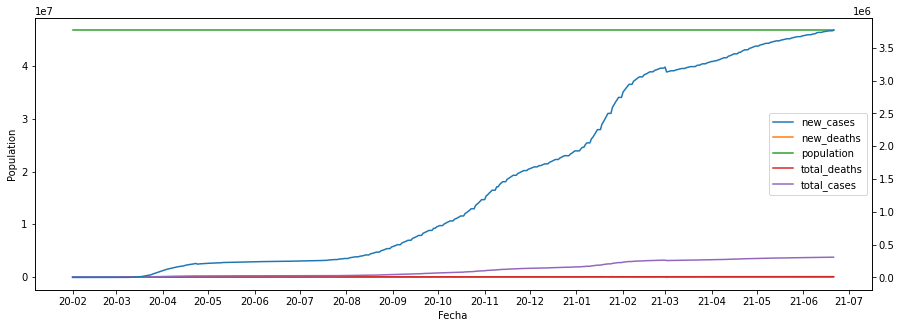

In [16]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(covid_spain.index, covid_spain, label = covid_spain.columns.to_list())
ax.set_ylabel('Population')
ax2 = ax.twinx()
ax2.plot(covid_spain.index, covid_spain.total_cases, label= 'Total Cases')
date_form = DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_xlabel('Fecha')
lines1, labels1 = ax.get_legend_handles_labels()
ax.legend(lines1, labels1);

In [17]:
covid_spain.iloc[:,1:]

new_deaths  population  total_deaths  total_cases
date                                                         
2020-02-01         NaN  46754783.0           NaN          1.0
2020-02-02         NaN  46754783.0           NaN          1.0
2020-02-03         NaN  46754783.0           NaN          1.0
2020-02-04         NaN  46754783.0           NaN          1.0
2020-02-05         NaN  46754783.0           NaN          1.0
...                ...         ...           ...          ...
2021-06-17        19.0  46754783.0       80634.0    3753228.0
2021-06-18        18.0  46754783.0       80652.0    3757442.0
2021-06-19         0.0  46754783.0       80652.0    3757442.0
2021-06-20         0.0  46754783.0       80652.0    3757442.0
2021-06-21        37.0  46754783.0       80689.0    3764651.0

[507 rows x 4 columns]

In [18]:
covid_spain[['total_cases', 'new_deaths', 'total_deaths']]

total_cases  new_deaths  total_deaths
date                                             
2020-02-01          1.0         NaN           NaN
2020-02-02          1.0         NaN           NaN
2020-02-03          1.0         NaN           NaN
2020-02-04          1.0         NaN           NaN
2020-02-05          1.0         NaN           NaN
...                 ...         ...           ...
2021-06-17    3753228.0        19.0       80634.0
2021-06-18    3757442.0        18.0       80652.0
2021-06-19    3757442.0         0.0       80652.0
2021-06-20    3757442.0         0.0       80652.0
2021-06-21    3764651.0        37.0       80689.0

[507 rows x 3 columns]

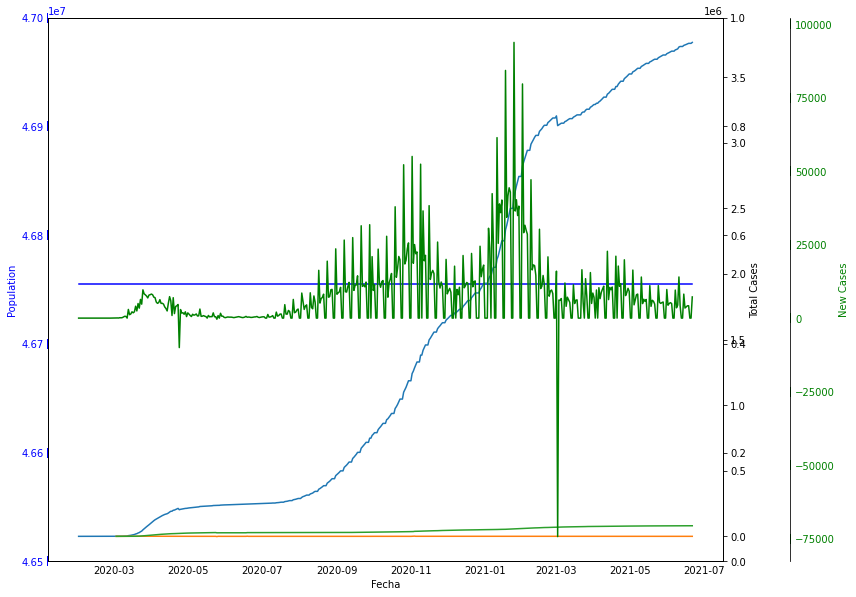

In [19]:
fig, ax = plt.subplots(figsize= (15,10))
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()
twin3 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
twin2.spines.right.set_position(("axes", 1.1))

p1, = ax.plot(covid_spain.index, covid_spain.population, "b-", label="Population")
p2 = twin1.plot(covid_spain.index, covid_spain[['total_cases', 'new_deaths', 'total_deaths']], label=covid_spain[['total_cases', 'new_deaths', 'total_deaths']].columns.tolist())
p3, = twin2.plot(covid_spain.index, covid_spain.new_cases, "g-", label="New cases")

#ax.set_xlim(0, 2)
ax.set_ylim(46500000, 47000000)
#twin1.set_ylim(0, 4)
#twin2.set_ylim(1, 65)

ax.set_xlabel("Fecha")
ax.set_ylabel("Population")
twin1.set_ylabel("Total Cases")
twin2.set_ylabel("New Cases")

ax.yaxis.label.set_color(p1.get_color())
#twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=1, width=10)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
#twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

#ax.legend(handles=[p1, p2, p3])

plt.show()

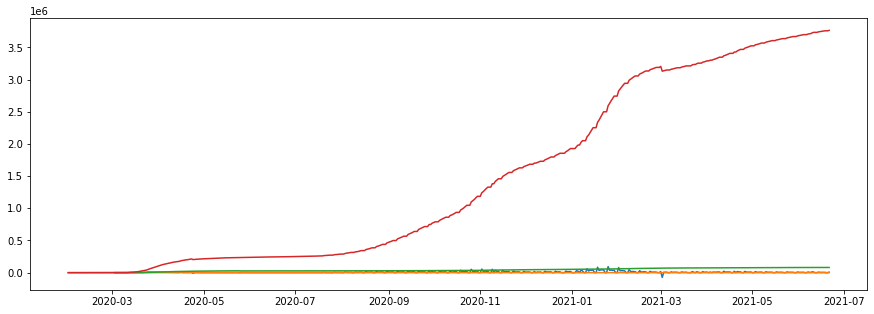

In [20]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(covid_spain.index, covid_spain.drop('population', axis=1), label = covid_spain.drop('population', axis=1).columns.tolist())

In [21]:
covid_spain.index = pd.to_datetime(covid_spain.index)

In [22]:
covid_spain.index

DatetimeIndex(['2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04',
               '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08',
               '2020-02-09', '2020-02-10',
               ...
               '2021-06-12', '2021-06-13', '2021-06-14', '2021-06-15',
               '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-19',
               '2021-06-20', '2021-06-21'],
              dtype='datetime64[ns]', name='date', length=507, freq=None)

# Elimina la columna población

In [23]:
covid_spain.drop(['population'], axis=1, inplace=True)
covid_spain

new_cases  new_deaths  total_deaths  total_cases
date                                                        
2020-02-01        1.0         NaN           NaN          1.0
2020-02-02        0.0         NaN           NaN          1.0
2020-02-03        0.0         NaN           NaN          1.0
2020-02-04        0.0         NaN           NaN          1.0
2020-02-05        0.0         NaN           NaN          1.0
...               ...         ...           ...          ...
2021-06-17     4197.0        19.0       80634.0    3753228.0
2021-06-18     4214.0        18.0       80652.0    3757442.0
2021-06-19        0.0         0.0       80652.0    3757442.0
2021-06-20        0.0         0.0       80652.0    3757442.0
2021-06-21     7209.0        37.0       80689.0    3764651.0

[507 rows x 4 columns]

## 3. Entrena los algoritmos de regresión que hemos visto hasta ahora para predecir dos columnas por separado: Nuevos casos y Nuevos fallecidos. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

In [24]:
covid_spain.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 507 entries, 2020-02-01 to 2021-06-21
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   new_cases     507 non-null    float64
 1   new_deaths    476 non-null    float64
 2   total_deaths  476 non-null    float64
 3   total_cases   507 non-null    float64
dtypes: float64(4)
memory usage: 19.8 KB


In [25]:
covid_spain.corr()

new_cases  new_deaths  total_deaths  total_cases
new_cases      1.000000    0.434187      0.121054     0.196613
new_deaths     0.434187    1.000000     -0.096491    -0.010781
total_deaths   0.121054   -0.096491      1.000000     0.972803
total_cases    0.196613   -0.010781      0.972803     1.000000

In [26]:
covid_spain.dropna(inplace=True)
covid_spain

new_cases  new_deaths  total_deaths  total_cases
date                                                        
2020-03-03       45.0         1.0           1.0        165.0
2020-03-04       57.0         1.0           2.0        222.0
2020-03-05       37.0         1.0           3.0        259.0
2020-03-06      141.0         2.0           5.0        400.0
2020-03-07      100.0         5.0          10.0        500.0
...               ...         ...           ...          ...
2021-06-17     4197.0        19.0       80634.0    3753228.0
2021-06-18     4214.0        18.0       80652.0    3757442.0
2021-06-19        0.0         0.0       80652.0    3757442.0
2021-06-20        0.0         0.0       80652.0    3757442.0
2021-06-21     7209.0        37.0       80689.0    3764651.0

[476 rows x 4 columns]

In [27]:
covid_spain.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 2020-03-03 to 2021-06-21
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   new_cases     476 non-null    float64
 1   new_deaths    476 non-null    float64
 2   total_deaths  476 non-null    float64
 3   total_cases   476 non-null    float64
dtypes: float64(4)
memory usage: 18.6 KB


In [28]:
x = np.array(covid_spain.drop(['new_cases'], axis=1))
print('x.shape:', x.shape)
y = np.array(covid_spain['new_cases'])
print('y.shape:', y.shape)

x.shape: (476, 3)
y.shape: (476,)


In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

x_train: (380, 3)
x_test: (96, 3)
y_train: (380,)
y_test: (96,)


In [30]:
linear_model = LinearRegression()

In [34]:
repkfold = RepeatedKFold(n_splits=23, n_repeats=7, random_state=42)

lista_RMSE_train = []
lista_RMSE_val = []
lista_MAE_train = []
lista_MAE_val = []
lista_score_train = []
lista_score_val = []

epoca = 1
for i, (train_index, val_index) in enumerate(repkfold.split(x_train, y_train)):
    
    print('ITERACION', i+1)
    print('\ntrain:', train_index)
    print('val:', val_index)
    
    x_train_cv, x_val_cv = x_train[train_index], x_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    linear_model.fit(x_train_cv, y_train_cv)
    score_train = linear_model.score(x_train_cv, y_train_cv)
    lista_score_train.append(score_train)
    print('Score Train:', score_train)
    score_val = linear_model.score(x_val_cv, y_val_cv)
    lista_score_val.append(score_val)
    print('Score Val:', score_val)
    prediccion_y_train = linear_model.predict(x_train_cv)
    prediccion_y_val = linear_model.predict(x_val_cv)
    rmse_error_train = np.sqrt(mean_squared_error(y_train_cv, prediccion_y_train))
    lista_RMSE_train .append(rmse_error_train)
    rmse_error_val = np.sqrt(mean_squared_error(y_val_cv, prediccion_y_val))
    lista_RMSE_val.append(rmse_error_val)
    mae_error_train = mean_absolute_error(y_train_cv, prediccion_y_train)
    lista_MAE_train.append(mae_error_train)

    mae_error_val = mean_absolute_error(y_val_cv, prediccion_y_val)
    lista_MAE_val.append(mae_error_val)
    print('RMSE error y_train:', rmse_error_train)
    print('RMSE error y_val:', rmse_error_val)
    print('MAE error y_train:', mae_error_train)
    print('MAE error y_val:', mae_error_val)
    
    if (i+1) % 23 == 0:
        print('\n\n----------     F I N    E P O C A   ' + str(epoca) + '  ----------\n\n')
        epoca += 1 
    print('\n========\n')

ITERACION 1

train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36
  37  38  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 235 236 237 238 239 240
 241 243 244 245 246 247 248 24

In [36]:
dic_epoc = {}
for i in range(7):
    dic_epoc[str(i)] = [lista_score_train[:23],lista_score_val[:23]]
    lista_score_train = lista_score_train[23:]
    lista_score_val = lista_score_val[23:]

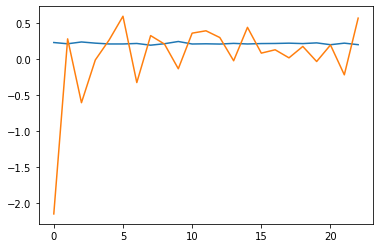

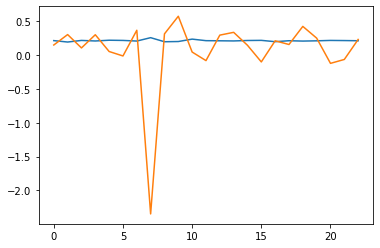

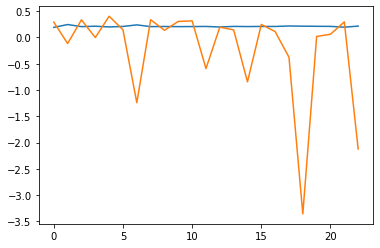

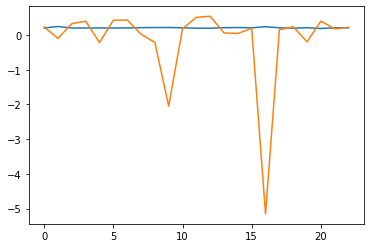

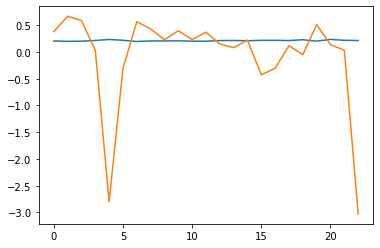

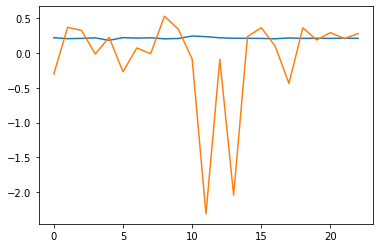

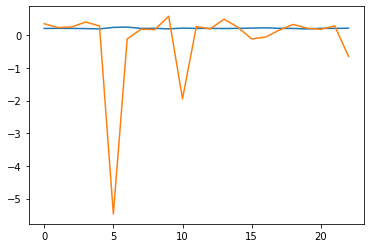

In [37]:
for key, value in dic_epoc.items():
    plt.plot(value[0])
    plt.plot(value[1])
    plt.show()

---

#  Regresion no lineal

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=42)
print('x_train.shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (380, 3)
x_test.shape: (96, 3)
y_train.shape: (380,)
y_test.shape: (96,)


In [39]:
model_pol = PolynomialFeatures(degree=6)

In [40]:
x_train_pol = model_pol.fit_transform(x_train, y_train)

In [41]:
x_train_pol.shape

(380, 84)

In [42]:
y.shape

(476,)

In [43]:
model_linreg_poly = LinearRegression()

In [44]:
repkfold = RepeatedKFold(n_splits=23, n_repeats=7, random_state=42)

lista_RMSE_train = []
lista_RMSE_val = []
lista_MAE_train = []
lista_MAE_val = []
lista_score_train = []
lista_score_val = []

epoca = 1
for i, (train_index, val_index) in enumerate(repkfold.split(x_train_pol, y_train)):
    
    print('ITERACION', i+1)
    print('\ntrain:', train_index)
    print('val:', val_index)
    
    x_train_cv, x_val_cv = x_train_pol[train_index], x_train_pol[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    model_linreg_poly.fit(x_train_cv, y_train_cv)
    score_train = model_linreg_poly.score(x_train_cv, y_train_cv)
    lista_score_train.append(score_train)
    print('Score Train:', score_train)
    score_val = model_linreg_poly.score(x_val_cv, y_val_cv)
    lista_score_val.append(score_val)
    print('Score Val:', score_val)
    prediccion_y_train = model_linreg_poly.predict(x_train_cv)
    prediccion_y_val = model_linreg_poly.predict(x_val_cv)
    rmse_error_train = np.sqrt(mean_squared_error(y_train_cv, prediccion_y_train))
    lista_RMSE_train .append(rmse_error_train)
    rmse_error_val = np.sqrt(mean_squared_error(y_val_cv, prediccion_y_val))
    lista_RMSE_val.append(rmse_error_val)
    mae_error_train = mean_absolute_error(y_train_cv, prediccion_y_train)
    lista_MAE_train.append(mae_error_train)
    mae_error_val = mean_absolute_error(y_val_cv, prediccion_y_val)
    lista_MAE_val.append(mae_error_val)
    print('RMSE error y_train:', rmse_error_train)
    print('RMSE error y_val:', rmse_error_val)
    print('MAE error y_train:', mae_error_train)
    print('MAE error y_val:', mae_error_val)
    #if epoca == 1:

    if (i+1) % 23 == 0:
        print('\n\n----------     F I N    E P O C A   ' + str(epoca) + '  ----------\n\n')
        epoca += 1 
    print('\n========\n')

ITERACION 1

train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36
  37  38  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 235 236 237 238 239 240
 241 243 244 245 246 247 248 24

In [45]:
dic_epoc = {}
for i in range(7):
    dic_epoc[str(i)] = [lista_score_train[:23],lista_score_val[:23]]
    lista_score_train = lista_score_train[23:]
    lista_score_val = lista_score_val[23:]

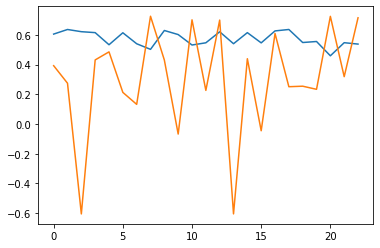

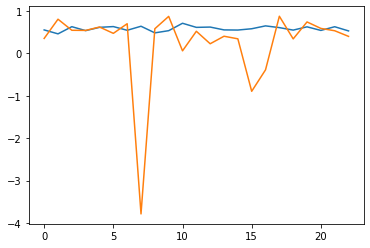

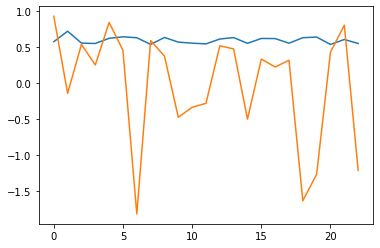

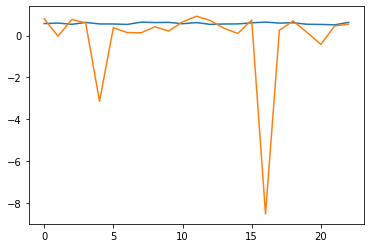

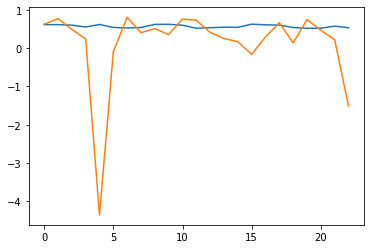

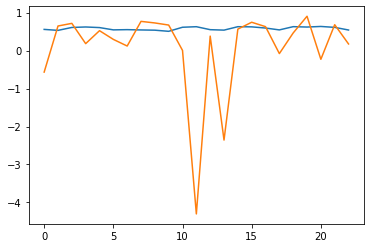

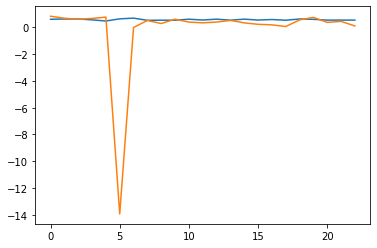

In [46]:
for key, value in dic_epoc.items():
    plt.plot(value[0])
    plt.plot(value[1])
    plt.show()

---

# SVR

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=42)
print('x_train.shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (380, 3)
x_test.shape: (96, 3)
y_train.shape: (380,)
y_test.shape: (96,)


In [49]:
model_svr = SVR()

In [53]:
repkfold = RepeatedKFold(n_splits=23, n_repeats=7, random_state=42)

lista_RMSE_train = []
lista_RMSE_val = []
lista_MAE_train = []
lista_MAE_val = []
lista_score_train = []
lista_score_val = []

epoca = 1
for i, (train_index, val_index) in enumerate(repkfold.split(x_train, y_train)):
    
    print('ITERACION', i+1)
    print('\ntrain:', train_index)
    print('val:', val_index)
    
    x_train_cv, x_val_cv = x_train[train_index], x_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    model_svr.fit(x_train_cv, y_train_cv)
    score_train = model_svr.score(x_train_cv, y_train_cv)
    lista_score_train.append(score_train)
    print('Score Train:', score_train)
    score_val = model_svr.score(x_val_cv, y_val_cv)
    lista_score_val.append(score_val)
    print('Score Val:', score_val)
    prediccion_y_train = model_svr.predict(x_train_cv)
    prediccion_y_val = model_svr.predict(x_val_cv)
    rmse_error_train = np.sqrt(mean_squared_error(y_train_cv, prediccion_y_train))
    lista_RMSE_train .append(rmse_error_train)
    rmse_error_val = np.sqrt(mean_squared_error(y_val_cv, prediccion_y_val))
    lista_RMSE_val.append(rmse_error_val)
    mae_error_train = mean_absolute_error(y_train_cv, prediccion_y_train)
    lista_MAE_train.append(mae_error_train)

    mae_error_val = mean_absolute_error(y_val_cv, prediccion_y_val)
    lista_MAE_val.append(mae_error_val)
    print('RMSE error y_train:', rmse_error_train)
    print('RMSE error y_val:', rmse_error_val)
    print('MAE error y_train:', mae_error_train)
    print('MAE error y_val:', mae_error_val)
    
    if (i+1) % 23 == 0:
        print('\n\n----------     F I N    E P O C A   ' + str(epoca) + '  ----------\n\n')
        epoca += 1 
    print('\n========\n')

ITERACION 1

train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36
  37  38  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 235 236 237 238 239 240
 241 243 244 245 246 247 248 24

In [54]:
dic_epoc = {}
for i in range(7):
    dic_epoc[str(i)] = [lista_score_train[:23],lista_score_val[:23]]
    lista_score_train = lista_score_train[23:]
    lista_score_val = lista_score_val[23:]

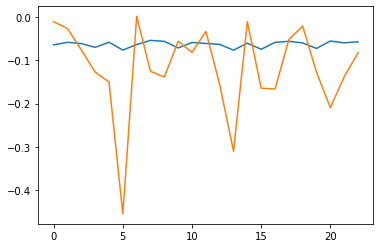

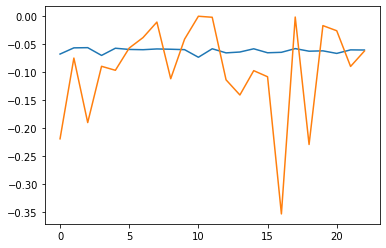

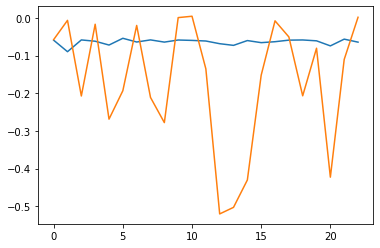

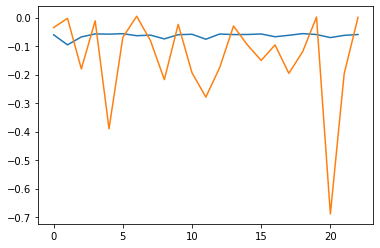

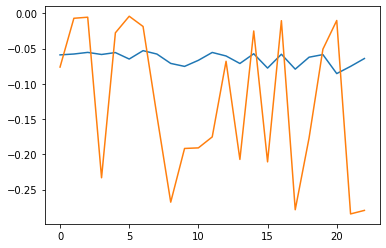

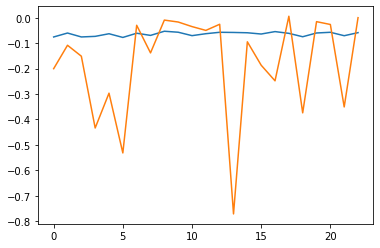

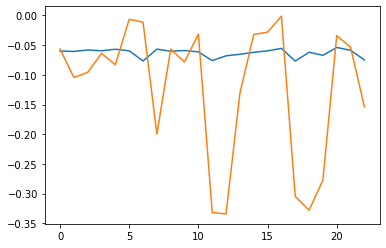

In [55]:
for key, value in dic_epoc.items():
    plt.plot(value[0])
    plt.plot(value[1])
    plt.show()

---

# Random Forest Regression

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=42)
print('x_train.shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (380, 3)
x_test.shape: (96, 3)
y_train.shape: (380,)
y_test.shape: (96,)


In [56]:
model_ranfor = RandomForestRegressor()

In [58]:
repkfold = RepeatedKFold(n_splits=23, n_repeats=7, random_state=42)

lista_RMSE_train = []
lista_RMSE_val = []
lista_MAE_train = []
lista_MAE_val = []
lista_score_train = []
lista_score_val = []

epoca = 1
for i, (train_index, val_index) in enumerate(repkfold.split(x_train, y_train)):
    
    print('ITERACION', i+1)
    print('\ntrain:', train_index)
    print('val:', val_index)
    
    x_train_cv, x_val_cv = x_train[train_index], x_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    model_ranfor.fit(x_train_cv, y_train_cv)
    score_train = model_ranfor.score(x_train_cv, y_train_cv)
    lista_score_train.append(score_train)
    print('Score Train:', score_train)
    score_val = model_ranfor.score(x_val_cv, y_val_cv)
    lista_score_val.append(score_val)
    print('Score Val:', score_val)
    prediccion_y_train = model_ranfor.predict(x_train_cv)
    prediccion_y_val = model_ranfor.predict(x_val_cv)
    rmse_error_train = np.sqrt(mean_squared_error(y_train_cv, prediccion_y_train))
    lista_RMSE_train .append(rmse_error_train)
    rmse_error_val = np.sqrt(mean_squared_error(y_val_cv, prediccion_y_val))
    lista_RMSE_val.append(rmse_error_val)
    mae_error_train = mean_absolute_error(y_train_cv, prediccion_y_train)
    lista_MAE_train.append(mae_error_train)

    mae_error_val = mean_absolute_error(y_val_cv, prediccion_y_val)
    lista_MAE_val.append(mae_error_val)
    print('RMSE error y_train:', rmse_error_train)
    print('RMSE error y_val:', rmse_error_val)
    print('MAE error y_train:', mae_error_train)
    print('MAE error y_val:', mae_error_val)
    
    if (i+1) % 23 == 0:
        print('\n\n----------     F I N    E P O C A   ' + str(epoca) + '  ----------\n\n')
        epoca += 1 
    print('\n========\n')

ITERACION 1

train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36
  37  38  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 235 236 237 238 239 240
 241 243 244 245 246 247 248 24

In [59]:
dic_epoc = {}
for i in range(7):
    dic_epoc[str(i)] = [lista_score_train[:23],lista_score_val[:23]]
    lista_score_train = lista_score_train[23:]
    lista_score_val = lista_score_val[23:]

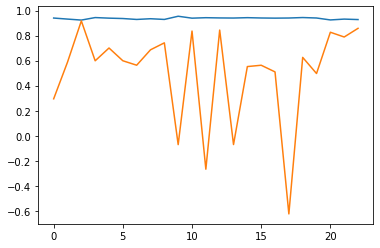

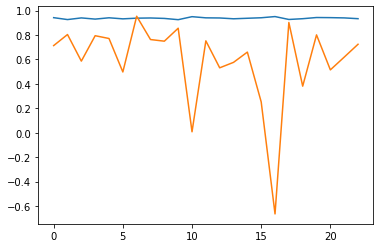

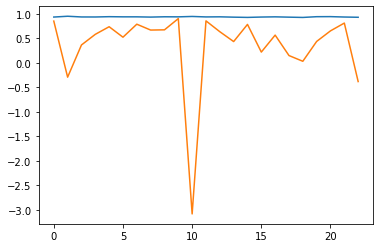

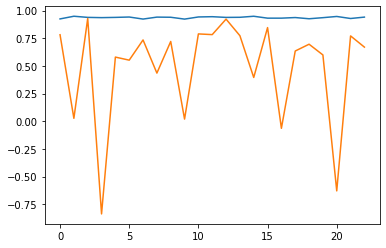

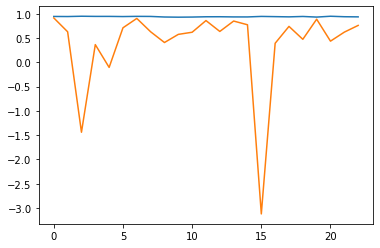

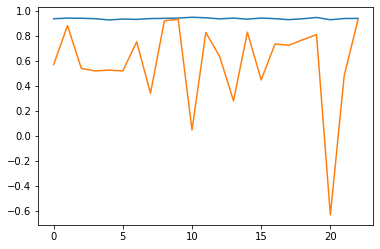

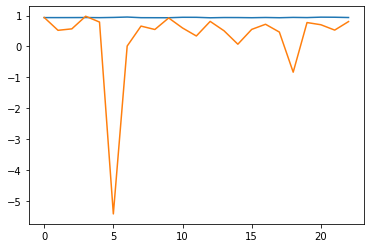

In [60]:
for key, value in dic_epoc.items():
    plt.plot(value[0])
    plt.plot(value[1])
    plt.show()

---

# Ahora Target = new_deaths

In [77]:
x = np.array(covid_spain.drop(['new_deaths'], axis=1))
print('x.shape:', x.shape)
y = np.array(covid_spain['new_deaths'])
print('y.shape:', y.shape)

x.shape: (476, 3)
y.shape: (476,)


In [78]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

x_train: (380, 3)
x_test: (96, 3)
y_train: (380,)
y_test: (96,)


In [79]:
linear_model = LinearRegression()

In [80]:
repkfold = RepeatedKFold(n_splits=23, n_repeats=7, random_state=42)

lista_RMSE_train = []
lista_RMSE_val = []
lista_MAE_train = []
lista_MAE_val = []
lista_score_train = []
lista_score_val = []

epoca = 1
for i, (train_index, val_index) in enumerate(repkfold.split(x_train, y_train)):
    
    print('ITERACION', i+1)
    print('\ntrain:', train_index)
    print('val:', val_index)
    
    x_train_cv, x_val_cv = x_train[train_index], x_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    linear_model.fit(x_train_cv, y_train_cv)
    score_train = linear_model.score(x_train_cv, y_train_cv)
    lista_score_train.append(score_train)
    print('Score Train:', score_train)
    score_val = linear_model.score(x_val_cv, y_val_cv)
    lista_score_val.append(score_val)
    print('Score Val:', score_val)
    prediccion_y_train = linear_model.predict(x_train_cv)
    prediccion_y_val = linear_model.predict(x_val_cv)
    rmse_error_train = np.sqrt(mean_squared_error(y_train_cv, prediccion_y_train))
    lista_RMSE_train .append(rmse_error_train)
    rmse_error_val = np.sqrt(mean_squared_error(y_val_cv, prediccion_y_val))
    lista_RMSE_val.append(rmse_error_val)
    mae_error_train = mean_absolute_error(y_train_cv, prediccion_y_train)
    lista_MAE_train.append(mae_error_train)

    mae_error_val = mean_absolute_error(y_val_cv, prediccion_y_val)
    lista_MAE_val.append(mae_error_val)
    print('RMSE error y_train:', rmse_error_train)
    print('RMSE error y_val:', rmse_error_val)
    print('MAE error y_train:', mae_error_train)
    print('MAE error y_val:', mae_error_val)
    
    if (i+1) % 23 == 0:
        print('\n\n----------     F I N    E P O C A   ' + str(epoca) + '  ----------\n\n')
        epoca += 1 
    print('\n========\n')

ITERACION 1

train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36
  37  38  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 235 236 237 238 239 240
 241 243 244 245 246 247 248 24

In [81]:
dic_epoc = {}
for i in range(7):
    dic_epoc[str(i)] = [lista_score_train[:23],lista_score_val[:23]]
    lista_score_train = lista_score_train[23:]
    lista_score_val = lista_score_val[23:]

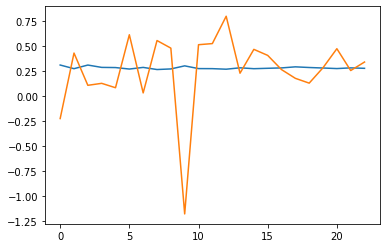

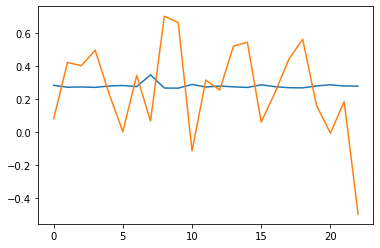

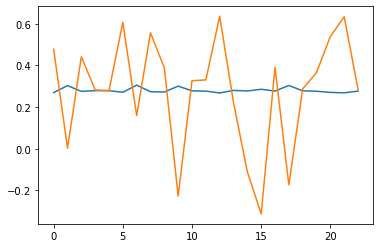

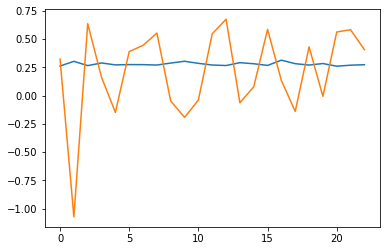

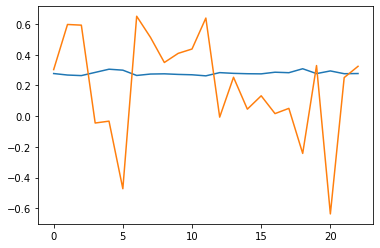

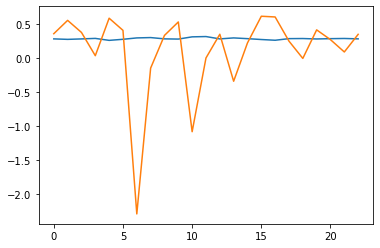

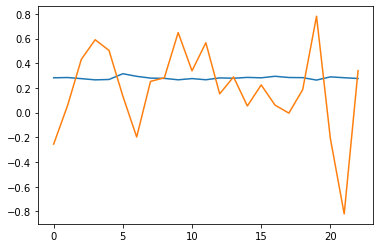

In [83]:
for key, value in dic_epoc.items():
    plt.plot(value[0])
    plt.plot(value[1])
    plt.show()

---

# NON LINEAR

In [114]:
x = np.array(covid_spain.drop(['new_deaths'], axis=1))
print('x.shape:', x.shape)
y = np.array(covid_spain['new_deaths'])
print('y.shape:', y.shape)

x.shape: (476, 3)
y.shape: (476,)


In [115]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=42)
print('x_train.shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (380, 3)
x_test.shape: (96, 3)
y_train.shape: (380,)
y_test.shape: (96,)


In [116]:
model_pol = PolynomialFeatures(degree=6)

In [117]:
x_train_pol = model_pol.fit_transform(x_train, y_train)

In [118]:
x_train_pol.shape

(380, 84)

In [119]:
y.shape

(476,)

In [120]:
model_linreg_poly = LinearRegression()

In [121]:
repkfold = RepeatedKFold(n_splits=23, n_repeats=7, random_state=42)

lista_RMSE_train = []
lista_RMSE_val = []
lista_MAE_train = []
lista_MAE_val = []
lista_score_train = []
lista_score_val = []

epoca = 1
for i, (train_index, val_index) in enumerate(repkfold.split(x_train_pol, y_train)):
    
    print('ITERACION', i+1)
    print('\ntrain:', train_index)
    print('val:', val_index)
    
    x_train_cv, x_val_cv = x_train_pol[train_index], x_train_pol[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    model_linreg_poly.fit(x_train_cv, y_train_cv)
    score_train = model_linreg_poly.score(x_train_cv, y_train_cv)
    lista_score_train.append(score_train)
    print('Score Train:', score_train)
    score_val = model_linreg_poly.score(x_val_cv, y_val_cv)
    lista_score_val.append(score_val)
    print('Score Val:', score_val)
    prediccion_y_train = model_linreg_poly.predict(x_train_cv)
    prediccion_y_val = model_linreg_poly.predict(x_val_cv)
    rmse_error_train = np.sqrt(mean_squared_error(y_train_cv, prediccion_y_train))
    lista_RMSE_train .append(rmse_error_train)
    rmse_error_val = np.sqrt(mean_squared_error(y_val_cv, prediccion_y_val))
    lista_RMSE_val.append(rmse_error_val)
    mae_error_train = mean_absolute_error(y_train_cv, prediccion_y_train)
    lista_MAE_train.append(mae_error_train)
    mae_error_val = mean_absolute_error(y_val_cv, prediccion_y_val)
    lista_MAE_val.append(mae_error_val)
    print('RMSE error y_train:', rmse_error_train)
    print('RMSE error y_val:', rmse_error_val)
    print('MAE error y_train:', mae_error_train)
    print('MAE error y_val:', mae_error_val)
    #if epoca == 1:

    if (i+1) % 23 == 0:
        print('\n\n----------     F I N    E P O C A   ' + str(epoca) + '  ----------\n\n')
        epoca += 1 
    print('\n========\n')

ITERACION 1

train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36
  37  38  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 235 236 237 238 239 240
 241 243 244 245 246 247 248 24

In [122]:
dic_epoc = {}
for i in range(7):
    dic_epoc[str(i)] = [lista_score_train[:23],lista_score_val[:23]]
    lista_score_train = lista_score_train[23:]
    lista_score_val = lista_score_val[23:]

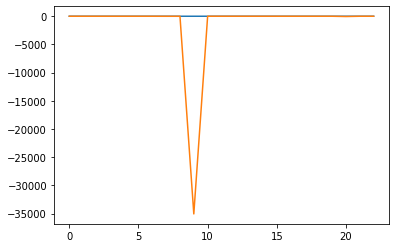

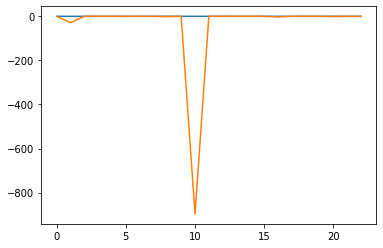

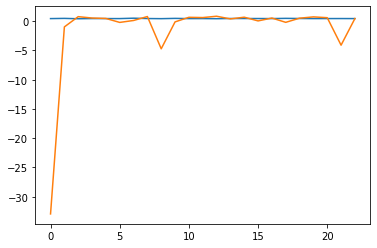

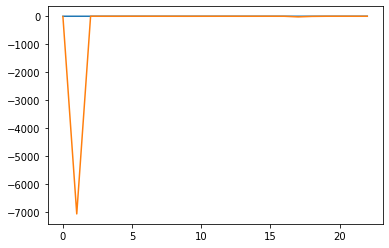

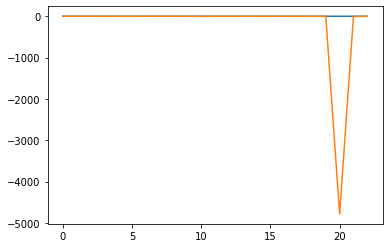

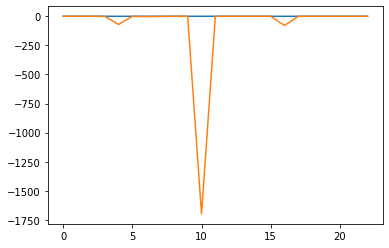

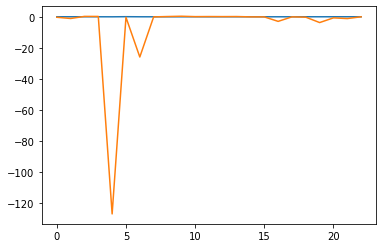

In [123]:
for key, value in dic_epoc.items():
    plt.plot(value[0])
    plt.plot(value[1])
    plt.show()

---

# SVR

In [124]:
x = np.array(covid_spain.drop(['new_deaths'], axis=1))
print('x.shape:', x.shape)
y = np.array(covid_spain['new_deaths'])
print('y.shape:', y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=42)
print('x_train.shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)

x.shape: (476, 3)
y.shape: (476,)
x_train.shape: (380, 3)
x_test.shape: (96, 3)
y_train.shape: (380,)
y_test.shape: (96,)


In [125]:
model_svr = SVR()

In [126]:
repkfold = RepeatedKFold(n_splits=23, n_repeats=7, random_state=42)

lista_RMSE_train = []
lista_RMSE_val = []
lista_MAE_train = []
lista_MAE_val = []
lista_score_train = []
lista_score_val = []

epoca = 1
for i, (train_index, val_index) in enumerate(repkfold.split(x_train, y_train)):
    
    print('ITERACION', i+1)
    print('\ntrain:', train_index)
    print('val:', val_index)
    
    x_train_cv, x_val_cv = x_train[train_index], x_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    model_svr.fit(x_train_cv, y_train_cv)
    score_train = model_svr.score(x_train_cv, y_train_cv)
    lista_score_train.append(score_train)
    print('Score Train:', score_train)
    score_val = model_svr.score(x_val_cv, y_val_cv)
    lista_score_val.append(score_val)
    print('Score Val:', score_val)
    prediccion_y_train = model_svr.predict(x_train_cv)
    prediccion_y_val = model_svr.predict(x_val_cv)
    rmse_error_train = np.sqrt(mean_squared_error(y_train_cv, prediccion_y_train))
    lista_RMSE_train .append(rmse_error_train)
    rmse_error_val = np.sqrt(mean_squared_error(y_val_cv, prediccion_y_val))
    lista_RMSE_val.append(rmse_error_val)
    mae_error_train = mean_absolute_error(y_train_cv, prediccion_y_train)
    lista_MAE_train.append(mae_error_train)

    mae_error_val = mean_absolute_error(y_val_cv, prediccion_y_val)
    lista_MAE_val.append(mae_error_val)
    print('RMSE error y_train:', rmse_error_train)
    print('RMSE error y_val:', rmse_error_val)
    print('MAE error y_train:', mae_error_train)
    print('MAE error y_val:', mae_error_val)
    
    if (i+1) % 23 == 0:
        print('\n\n----------     F I N    E P O C A   ' + str(epoca) + '  ----------\n\n')
        epoca += 1 
    print('\n========\n')

ITERACION 1

train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36
  37  38  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 235 236 237 238 239 240
 241 243 244 245 246 247 248 24

In [127]:
dic_epoc = {}
for i in range(7):
    dic_epoc[str(i)] = [lista_score_train[:23],lista_score_val[:23]]
    lista_score_train = lista_score_train[23:]
    lista_score_val = lista_score_val[23:]

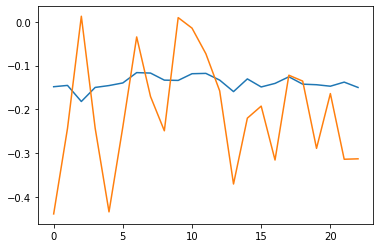

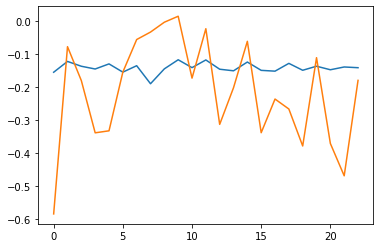

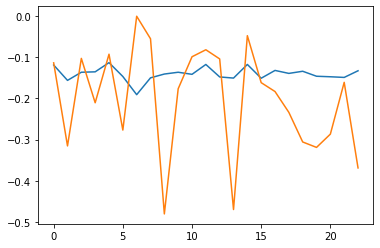

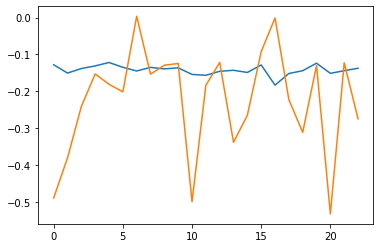

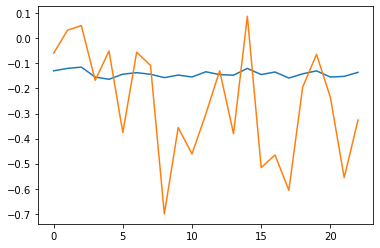

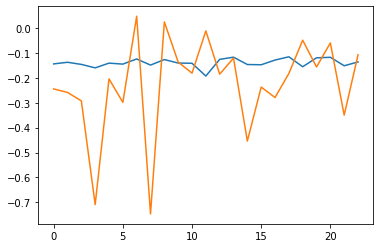

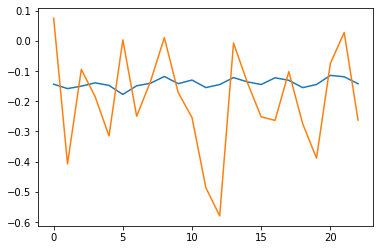

In [128]:
for key, value in dic_epoc.items():
    plt.plot(value[0])
    plt.plot(value[1])
    plt.show()

---

# Random Forest Regression

In [129]:
x = np.array(covid_spain.drop(['new_deaths'], axis=1))
print('x.shape:', x.shape)
y = np.array(covid_spain['new_deaths'])
print('y.shape:', y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=42)
print('x_train.shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)

x.shape: (476, 3)
y.shape: (476,)
x_train.shape: (380, 3)
x_test.shape: (96, 3)
y_train.shape: (380,)
y_test.shape: (96,)


In [130]:
model_ranfor = RandomForestRegressor()

In [131]:
repkfold = RepeatedKFold(n_splits=23, n_repeats=7, random_state=42)

lista_RMSE_train = []
lista_RMSE_val = []
lista_MAE_train = []
lista_MAE_val = []
lista_score_train = []
lista_score_val = []

epoca = 1
for i, (train_index, val_index) in enumerate(repkfold.split(x_train, y_train)):
    
    print('ITERACION', i+1)
    print('\ntrain:', train_index)
    print('val:', val_index)
    
    x_train_cv, x_val_cv = x_train[train_index], x_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    model_ranfor.fit(x_train_cv, y_train_cv)
    score_train = model_ranfor.score(x_train_cv, y_train_cv)
    lista_score_train.append(score_train)
    print('Score Train:', score_train)
    score_val = model_ranfor.score(x_val_cv, y_val_cv)
    lista_score_val.append(score_val)
    print('Score Val:', score_val)
    prediccion_y_train = model_ranfor.predict(x_train_cv)
    prediccion_y_val = model_ranfor.predict(x_val_cv)
    rmse_error_train = np.sqrt(mean_squared_error(y_train_cv, prediccion_y_train))
    lista_RMSE_train .append(rmse_error_train)
    rmse_error_val = np.sqrt(mean_squared_error(y_val_cv, prediccion_y_val))
    lista_RMSE_val.append(rmse_error_val)
    mae_error_train = mean_absolute_error(y_train_cv, prediccion_y_train)
    lista_MAE_train.append(mae_error_train)

    mae_error_val = mean_absolute_error(y_val_cv, prediccion_y_val)
    lista_MAE_val.append(mae_error_val)
    print('RMSE error y_train:', rmse_error_train)
    print('RMSE error y_val:', rmse_error_val)
    print('MAE error y_train:', mae_error_train)
    print('MAE error y_val:', mae_error_val)
    
    if (i+1) % 23 == 0:
        print('\n\n----------     F I N    E P O C A   ' + str(epoca) + '  ----------\n\n')
        epoca += 1 
    print('\n========\n')

ITERACION 1

train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36
  37  38  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 235 236 237 238 239 240
 241 243 244 245 246 247 248 24

In [132]:
dic_epoc = {}
for i in range(7):
    dic_epoc[str(i)] = [lista_score_train[:23],lista_score_val[:23]]
    lista_score_train = lista_score_train[23:]
    lista_score_val = lista_score_val[23:]

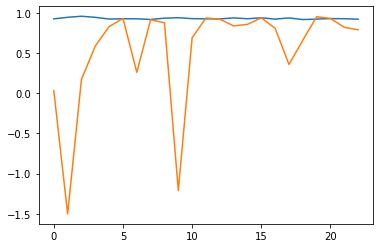

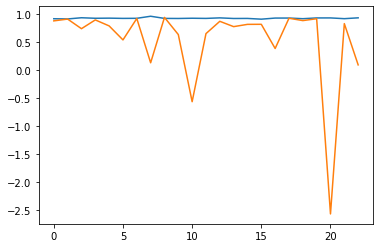

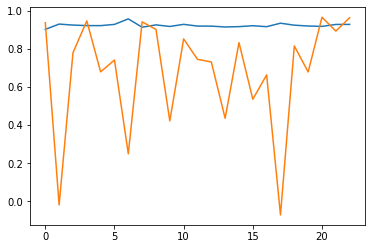

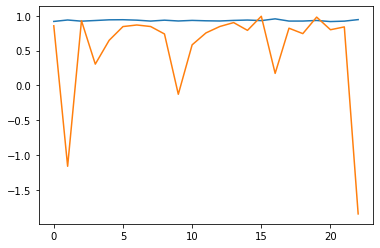

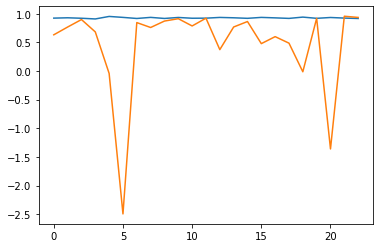

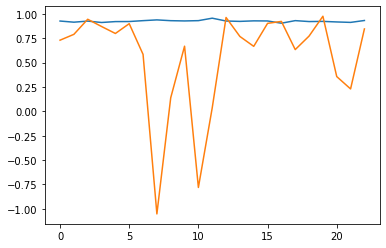

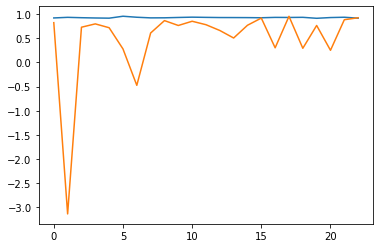

In [133]:
for key, value in dic_epoc.items():
    plt.plot(value[0])
    plt.plot(value[1])
    plt.show()